In [10]:
import pandas as pd

# Load the datasets
train_data = pd.read_csv('train.csv', low_memory=False)
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
metadata = pd.read_csv('metadata.csv')

# Display the first few rows of each dataset
train_head = train_data.head()
test_head = test_data.head()
sample_submission_head = sample_submission.head()
metadata_head = metadata.head()

train_head, test_head, sample_submission_head, metadata_head

(            team conf  GP  Min_per   Ortg   usg   eFG  TS_per  ORB_per  \
 0  South Alabama   SB  26     29.5   97.3  16.6  42.5   44.43      1.6   
 1       Utah St.  WAC  34     60.9  108.3  14.9  52.4   54.48      3.8   
 2  South Florida   BE  27     72.0   96.2  21.8  45.7   47.98      2.1   
 3     Pepperdine  WCC  30     44.5   97.7  16.0  53.6   53.69      4.1   
 4        Pacific   BW  33     56.2   96.5  22.0  52.8   54.31      8.3   
 
    DRB_per  ...     dgbpm    oreb    dreb    treb     ast     stl     blk  \
 0      4.6  ... -1.941150  0.1923  0.6154  0.8077  1.1923  0.3462  0.0385   
 1      6.3  ... -0.247934  0.6765  1.2647  1.9412  1.8235  0.4118  0.2353   
 2      8.0  ... -0.883163  0.6296  2.3333  2.9630  1.9630  0.4815  0.0000   
 3      9.4  ... -0.393459  0.7000  1.4333  2.1333  1.1000  0.5667  0.1333   
 4     18.6  ... -0.668318  1.4242  3.3030  4.7273  0.8485  0.4545  0.3333   
 
        pts                             player_id  drafted  
 0   3.8846  7be2

In [11]:
# Check for missing values in the train dataset
missing_values = train_data.isnull().sum()

# Filter out columns with missing values
missing_values = missing_values[missing_values > 0]

missing_values_percentage = (missing_values / len(train_data)) * 100

missing_values, missing_values_percentage

(yr                       274
 ht                        80
 num                     4669
 Rec_Rank               39055
 ast_tov                 4190
 rimmade                 6081
 rimmade_rimmiss         6081
 midmade                 6081
 midmade_midmiss         6081
 rim_ratio               9464
 mid_ratio               9688
 dunksmade               6081
 dunksmiss_dunksmade     6081
 dunks_ratio            30793
 pick                   54705
 drtg                      44
 adrtg                     44
 dporpag                   44
 stops                     44
 bpm                       44
 obpm                      44
 dbpm                      44
 gbpm                      44
 mp                        38
 ogbpm                     44
 dgbpm                     44
 oreb                      38
 dreb                      38
 treb                      38
 ast                       38
 stl                       38
 blk                       38
 pts                       38
 dtype: in

In [12]:
# Check the distribution of the target variable 'drafted'
drafted_distribution = train_data['drafted'].value_counts(normalize=True)

drafted_distribution

0.0    0.990444
1.0    0.009556
Name: drafted, dtype: float64

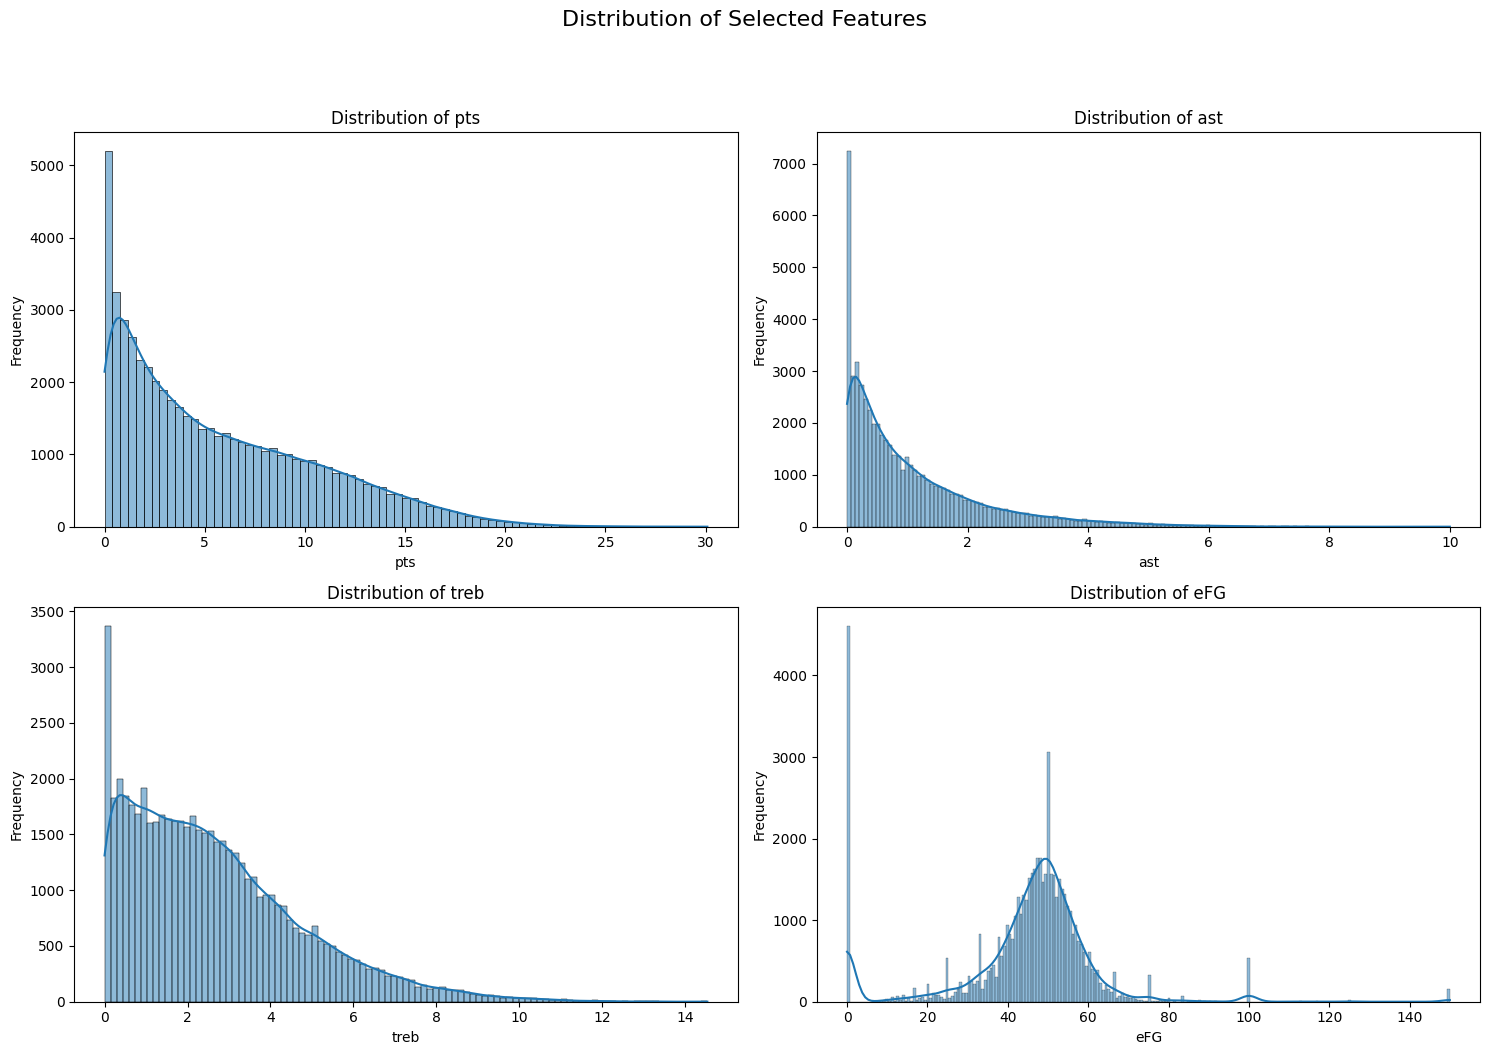

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to visualize
features_to_explore = ['pts', 'ast', 'treb', 'eFG']

# Set up the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribution of Selected Features', fontsize=16, y=1.05)

# Plot histograms for each feature
for i, feature in enumerate(features_to_explore):
    sns.histplot(train_data[feature], ax=axs[i//2, i%2], kde=True)
    axs[i//2, i%2].set_title(f'Distribution of {feature}')
    axs[i//2, i%2].set_xlabel(feature)
    axs[i//2, i%2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# Drop the column with very high missing values
train_data.drop(columns=['pick'], inplace=True)

# Update the columns with missing values after dropping 'pick'
missing_values_cols_updated = [col for col in missing_values.index if col != 'pick']

# Identify numeric and non-numeric columns among the updated list
numeric_cols = train_data[missing_values_cols_updated].select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = train_data[missing_values_cols_updated].select_dtypes(exclude=['float64', 'int64']).columns

# Handle missing values in numeric columns using the median
for column in numeric_cols:
    median_value = train_data[column].median()
    train_data[column].fillna(median_value, inplace=True)

# Handle missing values in non-numeric columns using the mode
for column in non_numeric_cols:
    mode_value = train_data[column].mode()[0]
    train_data[column].fillna(mode_value, inplace=True)

# Confirm if there are any more missing values
remaining_missing_values = train_data.isnull().sum().sum()

remaining_missing_values

0

In [24]:
from sklearn.metrics import pairwise_distances_argmin_min
from imblearn.over_sampling import SMOTE

# Separate features and target variable
X = train_data.drop(columns=['drafted'])
y = train_data['drafted']

# Identify and one-hot encode the categorical columns (excluding 'player_id')
categorical_cols = X.select_dtypes(include=['object']).columns.drop('player_id')
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Temporarily separate 'player_id' from the dataset
player_ids = X_encoded['player_id']
X_encoded_temp = X_encoded.drop(columns=['player_id'])

# Apply SMOTE on the temporary dataset without 'player_id'
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_temp, y)

# Re-integrate 'player_id' into the resampled dataset
# For each synthetic sample, find the closest original sample and use its player_id
closest_indices = pairwise_distances_argmin_min(X_resampled, X_encoded_temp)[0]
X_resampled['player_id'] = player_ids.iloc[closest_indices].values

# Check the new distribution of the target variable
resampled_distribution = y_resampled.value_counts(normalize=True)
print(resampled_distribution)

0.0    0.5
1.0    0.5
Name: drafted, dtype: float64


In [27]:
from sklearn.preprocessing import StandardScaler

# Apply standard scaling
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled.drop(columns=['player_id']))

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_pred_proba = clf.predict_proba(X_val)[:, 1]

# Evaluate the model using ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9999818147225285


In [34]:
from sklearn.model_selection import GridSearchCV

# Define the Parameter Grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Evaluate
best_grid = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model on the validation set
y_pred_proba_best = best_grid.predict_proba(X_val)[:, 1]
roc_auc_best = roc_auc_score(y_val, y_pred_proba_best)
print("ROC-AUC Score with Best Hyperparameters:", roc_auc_best)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
ROC-AUC Score with Best Hyperparameters: 0.9999825194526576


In [33]:
# Handle missing values in the test data similarly to the train data

# Drop the column 'pick' (if it exists in test data)
test_data.drop(columns=['pick'], inplace=True, errors='ignore')

# Handle missing values in numeric columns using the median
for column in numeric_cols:
    median_value = train_data[column].median()  # Use median from train data
    test_data[column].fillna(median_value, inplace=True)

# Handle missing values in non-numeric columns using the mode
for column in non_numeric_cols:
    mode_value = train_data[column].mode()[0]  # Use mode from train data
    test_data[column].fillna(mode_value, inplace=True)

# One-hot encode categorical variables in the test data

# Note: To ensure that the test data has the same columns as the training data after encoding,
# we'll use the `reindex` method

test_encoded = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)
missing_cols = set(X_encoded.columns) - set(test_encoded.columns) - {'player_id'}  # Find missing columns
for col in missing_cols:
    test_encoded[col] = 0  # Add missing columns with value 0
test_encoded = test_encoded[X_encoded.columns]  # Reorder columns to match train data

# Separate 'player_id' for later use
test_player_ids = test_encoded['player_id']
test_encoded_temp = test_encoded.drop(columns=['player_id'])

# 3. Apply standard scaling to the test data
test_encoded_scaled = scaler.transform(test_encoded_temp)  # Use the same scaler object from training

# 4. Predict probabilities using the trained model
test_predicted_probs = clf.predict_proba(test_encoded_scaled)[:, 1]

# 5. Prepare the submission DataFrame
submission = pd.DataFrame({'player_id': test_player_ids, 'drafted': test_predicted_probs})
submission.to_csv('submission.csv', index=False)

In [36]:
# 2. Predict probabilities using the best model
test_predicted_probs_best = best_grid.predict_proba(test_encoded_scaled)[:, 1]

# 3. Prepare the submission DataFrame
submission_best = pd.DataFrame({'player_id': test_player_ids, 'drafted': test_predicted_probs_best})
submission_best.to_csv('submission_best.csv', index=False)